In [1]:
import torch
import gpytorch
import pyproj

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
target_date = pd.to_datetime('2022-09-01')
# parquet_file_path = "/home/knowit/Home_Foresee/forseeModel/data/VMS_DCA_joined/makrell_not.parquet"
parquet_file_path = "/home/knowit/Home_Foresee/forseeModel/data/VMS_DCA_joined/cod_trawl.parquet"
df = pd.read_parquet(parquet_file_path).groupby('route_id').last().reset_index()
# df = df[df['position_time'] <= target_date]
df = df.sort_values('position_time')

# Univariate GP Regression

In [3]:
# ts = df[['position_time', 'roundweight']].rolling('1D', on='position_time').mean()#agg(['sum', 'mean', 'max'])
# ts = ts[ts['roundweight'] < 400_000]
# ts = ts.sample(3000)
ts = df[['position_time', 'roundweight']]
# ts = df[['position_time', 'roundweight']].rolling('1D', on='position_time').mean()#agg(['sum', 'mean', 'max'])
ts.loc[:,'position_time'] = ts['position_time'].dt.normalize()
ts = ts.groupby(pd.Grouper(key='position_time', freq='1D')).sum().reset_index()
ts = ts.sort_values('position_time')
ts

,position_time,roundweight
0,2011-01-01,328869
1,2011-01-02,300050
2,2011-01-03,379130
3,2011-01-04,397876
4,2011-01-05,661551
...,...,...
4442,2023-03-01,481681
4443,2023-03-02,345878
4444,2023-03-03,319621
4445,2023-03-04,290620


In [19]:
time = ((ts['position_time'] - pd.to_datetime(target_date)) / pd.Timedelta(seconds=86400)).values
X = torch.Tensor(time)
# X = torch.Tensor(ts['position_time'].astype('long').values)
y = torch.Tensor(ts['roundweight'].values)
# y = torch.Tensor(np.log1p(ts['roundweight'].values))

In [5]:
X /= 1000
y /= 1000

In [20]:
n = len(X)
train_ratio = 0.7
train_index = int(train_ratio*n)
train_x, test_x = X[:train_index], X[train_index:]
train_y, test_y = y[:train_index], y[train_index:]

In [21]:
# normalize features
x_mean = train_x.mean(dim=0, keepdim=True)
x_std = train_x.std(dim=0, keepdim=True) + 1e-6 # prevent dividing by 0
train_x = (train_x - x_mean) / x_std
test_x = (test_x - x_mean) / x_std

# normalize labels
y_mean, y_std = train_y.mean(),train_y.std()
train_y = (train_y - y_mean) / y_std
test_y = (test_y - y_mean) / y_std

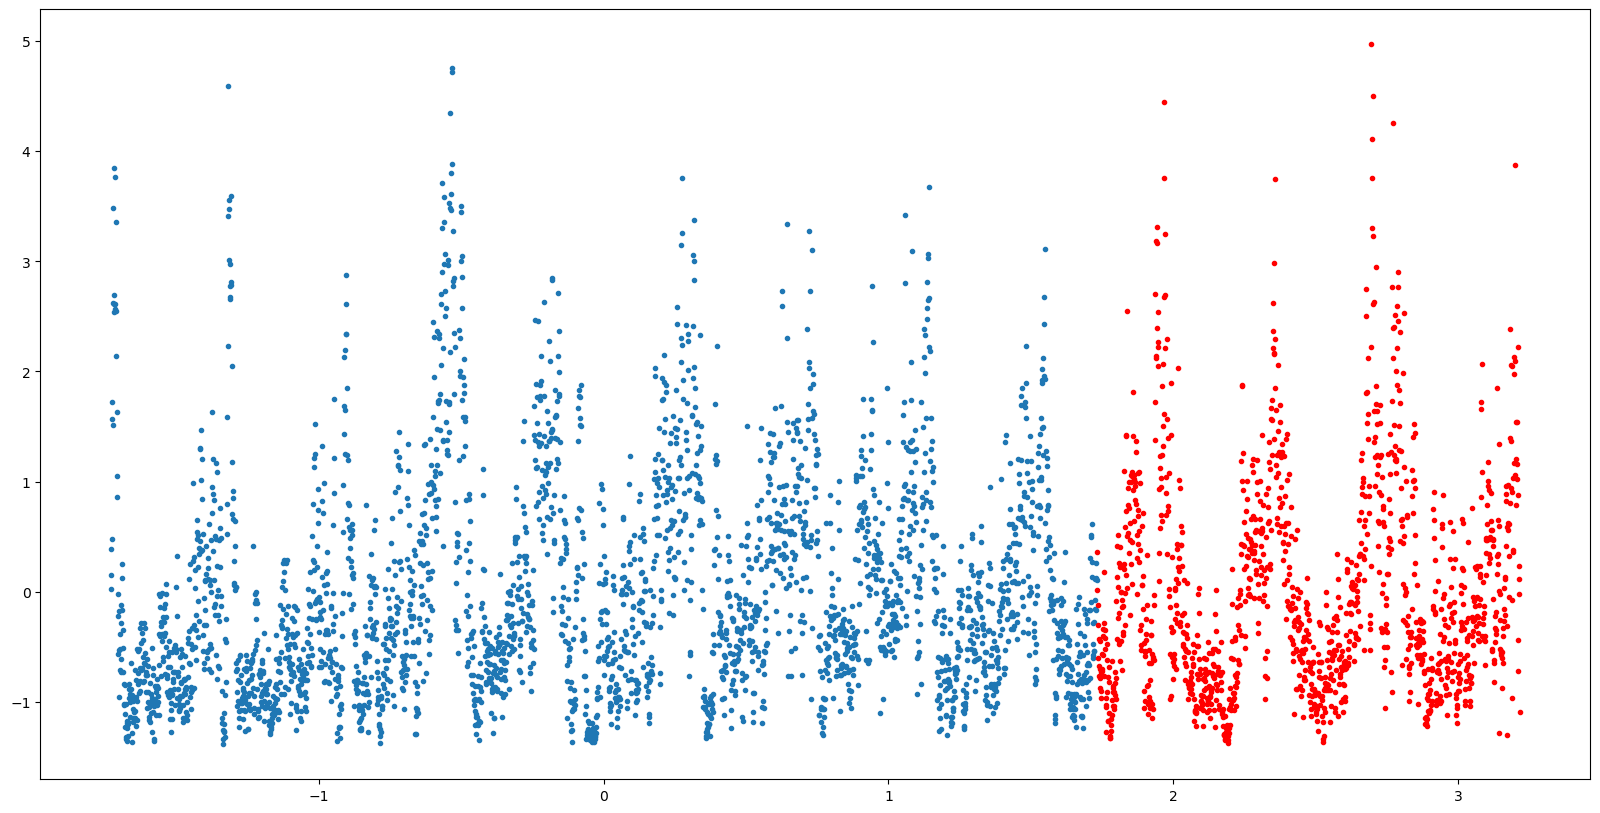

In [22]:
plt.figure(figsize=(20,10))
plt.plot(train_x, train_y, '.')
plt.plot(test_x, test_y, 'r.')
plt.show()

In [12]:
# make continguous
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [23]:
class PeriodicDecayGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel())
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() * gpytorch.kernels.CosineKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.05))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = PeriodicDecayGP(train_x, train_y, likelihood)

In [24]:
train_x = train_x.cuda()
train_y = train_y.cuda()
inference_x = torch.linspace(train_x.min(), test_x.max(), 501).cuda()

model = model.cuda()
likelihood = likelihood.cuda()

In [25]:
training_iter = 500
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
    #     i + 1, training_iter, loss.item(),
    #     model.covar_module.base_kernel.lengthscale.item(),
    #     # model.covar_module.base_kernel.period_length.item(),
    #     model.likelihood.noise.item()
    # ))
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/500 - Loss: 1.441   noise: 0.693
Iter 11/500 - Loss: 1.411   noise: 1.100
Iter 21/500 - Loss: 1.403   noise: 0.975
Iter 31/500 - Loss: 1.401   noise: 0.897
Iter 41/500 - Loss: 1.391   noise: 0.952
Iter 51/500 - Loss: 1.316   noise: 0.780
Iter 61/500 - Loss: 1.214   noise: 0.583
Iter 71/500 - Loss: 1.326   noise: 0.818
Iter 81/500 - Loss: 1.151   noise: 0.809
Iter 91/500 - Loss: 1.396   noise: 0.438
Iter 101/500 - Loss: 1.144   noise: 0.824
Iter 111/500 - Loss: 1.109   noise: 0.626
Iter 121/500 - Loss: 1.081   noise: 0.421
Iter 131/500 - Loss: 1.069   noise: 0.469
Iter 141/500 - Loss: 1.067   noise: 0.493
Iter 151/500 - Loss: 1.069   noise: 0.459
Iter 161/500 - Loss: 1.082   noise: 0.495
Iter 171/500 - Loss: 1.231   noise: 0.688
Iter 181/500 - Loss: 1.159   noise: 0.688
Iter 191/500 - Loss: 1.081   noise: 0.482
Iter 201/500 - Loss: 1.124   noise: 0.453
Iter 211/500 - Loss: 1.081   noise: 0.499
Iter 221/500 - Loss: 1.069   noise: 0.471
Iter 231/500 - Loss: 1.106   noise: 0.512
Ite

In [26]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(inference_x))
    f_preds = model(inference_x)
    # forecast = model(test_x)
    
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [27]:
mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
# test_x = test_x.cpu()
inference_x = inference_x.cpu()

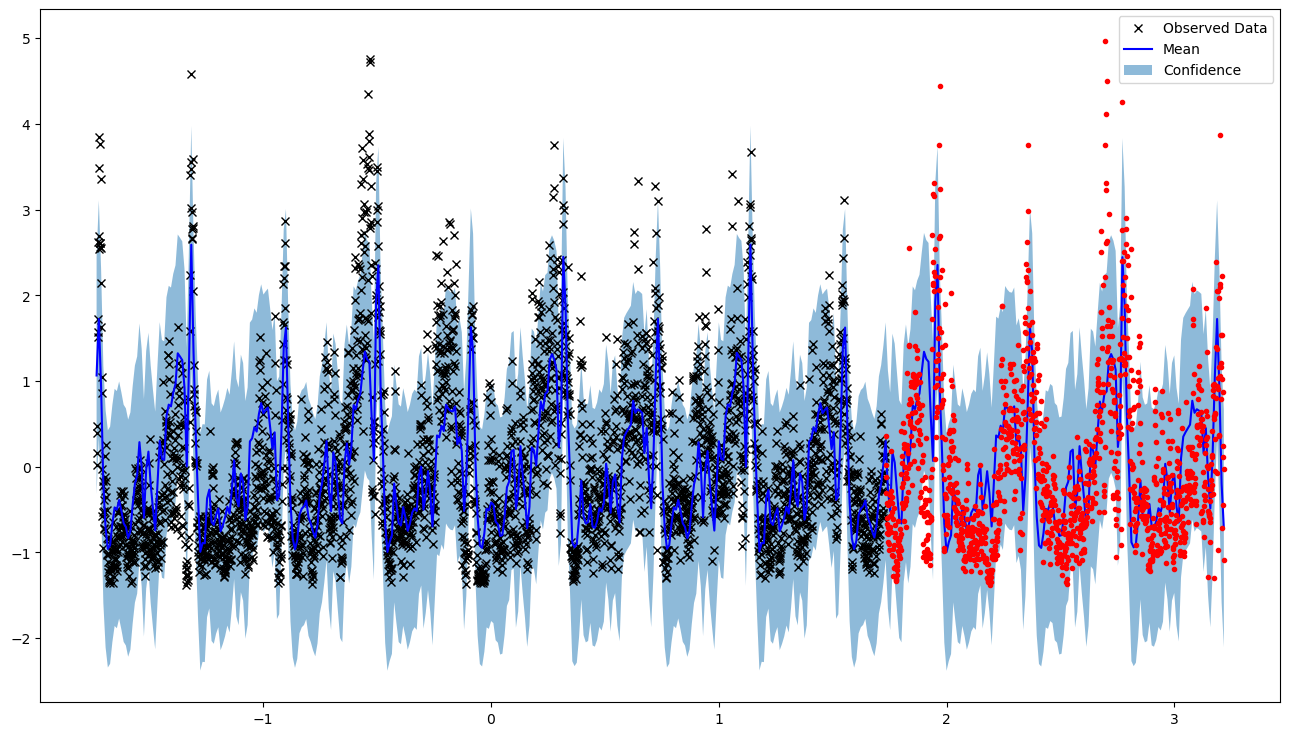

In [28]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(16,9))

    # ax.plot(test_x.numpy(), f(test_x), '--')
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'kx')
    # Plot predictive means as blue line
    ax.plot(inference_x.numpy(), mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(inference_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)

    ax.plot(test_x.numpy(), test_y.numpy(), 'r.')
    # f_lower, f_upper = f_preds.confidence_region()
    # ax.fill_between(test_x.numpy(), f_lower.numpy(), f_upper.numpy(), color='g', alpha=0.5)
    
    # ax.set_ylim([-2, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Multivariate GP Regression

In [3]:
ts = df[['roundweight', 'position_time', 'lon', 'lat']]

In [4]:
import xarray as xr
bio = xr.open_dataset('data/copernicus/nrt/resampled/bio_north_sea.nc')
bio

<xarray.Dataset>
Dimensions:  (x: 52, y: 94, time: 895)
Coordinates:
  * x        (x) float64 3.575e+06 3.588e+06 3.6e+06 ... 4.197e+06 4.21e+06
  * y        (y) float64 4.361e+06 4.349e+06 4.336e+06 ... 3.23e+06 3.218e+06
  * time     (time) datetime64[ns] 2020-11-01T12:00:00 ... 2023-04-14T12:00:00
Data variables:
    spco2    (time, y, x) float64 ...
    o2       (time, y, x) float64 ...
    chl      (time, y, x) float64 ...
    no3      (time, y, x) float64 ...
    po4      (time, y, x) float64 ...
    phyc     (time, y, x) float64 ...
    si       (time, y, x) float64 ...
    ph       (time, y, x) float64 ...
    talk     (time, y, x) float64 ...
    nppv     (time, y, x) float64 ...
    dissic   (time, y, x) float64 ...
    fe       (time, y, x) float64 ...
Attributes:
    EPSG:     3035

In [5]:
t = pyproj.Transformer.from_crs('4326', '3035', always_xy=True)
it = pyproj.Transformer.from_crs('3035', '4326', always_xy=True)
crs_x, crs_y = t.transform(ts['lon'], ts['lat'])
ts.loc[:,'x'] = crs_x
ts.loc[:,'y'] = crs_y

/tmp/ipykernel_860916/645261494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.loc[:,'x'] = crs_x
/tmp/ipykernel_860916/645261494.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.loc[:,'y'] = crs_y


In [6]:
grid_x, grid_y = bio.x.values, bio.y.values
x_min, x_max = grid_x.min(), grid_x.max()
y_min, y_max = grid_y.min(), grid_y.max()
x_step = np.abs(grid_x[1] - grid_x[0])
y_step = np.abs(grid_y[1] - grid_y[0])

In [7]:
ts = ts[ts['x'].between(x_min, x_max)]
ts = ts[ts['y'].between(y_min, y_max)]

x_idx = np.round((ts['x'] - x_min) / x_step)
y_idx = np.round((ts['y'] - y_min) / y_step)

In [8]:
ts['x_round'] = x_min + x_idx * x_step
ts['y_round'] = y_min + y_idx * y_step
ts['t_round'] = ts['position_time'].dt.normalize()

In [9]:
df_round = ts.groupby(['t_round', 'x_round', 'y_round']).agg({'roundweight': 'sum'}).reset_index()
df_round = df_round.sort_values('t_round')
df_round

,t_round,x_round,y_round,roundweight
0,2011-01-01,4.159814e+06,3.832535e+06,120
1,2011-01-01,4.184697e+06,3.832535e+06,90
2,2011-01-02,4.159814e+06,3.820245e+06,30
3,2011-01-02,4.209579e+06,3.820245e+06,78
4,2011-01-03,3.960755e+06,3.967727e+06,140
...,...,...,...,...
69456,2023-03-05,3.935872e+06,4.188949e+06,227
69453,2023-03-05,3.898549e+06,4.250400e+06,60
69454,2023-03-05,3.910990e+06,4.238109e+06,40
69455,2023-03-05,3.923431e+06,4.225819e+06,30


In [10]:
X = np.zeros((len(df_round), 3))
X[:,0] = (df_round['t_round'] - pd.to_datetime(target_date)) / pd.Timedelta(seconds=86400)
X[:,1] = df_round['x_round']
X[:,2] = df_round['y_round']
X = torch.Tensor(X)

In [11]:
# y = np.log(df['roundweight'] + 1.)
y = df_round['roundweight'].values
y = torch.Tensor(y)

In [17]:
n = X.shape[0]
train_ratio = 0.7
train_index = int(train_ratio*n)
train_x, test_x = X[:train_index], X[train_index:]
train_y, test_y = y[:train_index], y[train_index:]

In [18]:
# normalize features
x_mean = train_x.mean(dim=0, keepdim=True)
x_std = train_x.std(dim=0, keepdim=True) + 1e-6 # prevent dividing by 0
train_x = (train_x - x_mean) / x_std
test_x = (test_x - x_mean) / x_std

# normalize labels
y_mean, y_std = train_y.mean(),train_y.std()
train_y = (train_y - y_mean) / y_std
test_y = (test_y - y_mean) / y_std

In [19]:
class PeriodicDecayGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.CosineKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(active_dims=[1,2]) + gpytorch.kernels.PeriodicKernel(active_dims=[0])
        )
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() * gpytorch.kernels.CosineKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(0.05))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = PeriodicDecayGP(train_x, train_y, likelihood)

In [20]:
# make continguous
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:1')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

In [21]:
model.to(output_device)
likelihood.to(output_device)

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [15]:
train_x = train_x.cuda()
train_y = train_y.cuda()

model = model.cuda()
likelihood = likelihood.cuda()

In [22]:
training_iter = 200
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

OutOfMemoryError: CUDA out of memory. Tried to allocate 8.81 GiB (GPU 1; 15.70 GiB total capacity; 8.82 GiB already allocated; 6.59 GiB free; 8.83 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
import xarray as xr
bio = xr.open_dataset('data/copernicus/nrt/resampled/bio_north_sea.nc')
bio

<xarray.Dataset>
Dimensions:  (x: 52, y: 94, time: 895)
Coordinates:
  * x        (x) float64 3.575e+06 3.588e+06 3.6e+06 ... 4.197e+06 4.21e+06
  * y        (y) float64 4.361e+06 4.349e+06 4.336e+06 ... 3.23e+06 3.218e+06
  * time     (time) datetime64[ns] 2020-11-01T12:00:00 ... 2023-04-14T12:00:00
Data variables:
    spco2    (time, y, x) float64 ...
    o2       (time, y, x) float64 ...
    chl      (time, y, x) float64 ...
    no3      (time, y, x) float64 ...
    po4      (time, y, x) float64 ...
    phyc     (time, y, x) float64 ...
    si       (time, y, x) float64 ...
    ph       (time, y, x) float64 ...
    talk     (time, y, x) float64 ...
    nppv     (time, y, x) float64 ...
    dissic   (time, y, x) float64 ...
    fe       (time, y, x) float64 ...
Attributes:
    EPSG:     3035

In [13]:
from global_land_mask import globe


grid_x, grid_y = np.meshgrid(bio.x, bio.y)
# grid_x_flat = grid_x.ravel()
# grid_y_flat = grid_y.ravel()

lon_grid, lat_grid = it.transform(grid_x, grid_y)
ocean_mask = globe.is_ocean(lat_grid, lon_grid)

In [14]:
def get_7day_grid(x_grid, y_grid, ocean_mask, from_epsg, to_epsg):
    x_grid_flat = x_grid.flatten()
    y_grid_flat = y_grid.flatten()
    ocean_mask_flat = ocean_mask.flatten()

    if from_epsg != to_epsg:
        t = pyproj.Transformer.from_crs(from_epsg, to_epsg, always_xy=True)
        x_grid_flat, y_grid_flat = t.transform(x_grid_flat, y_grid_flat)

    # x_grid_flat[~ocean_mask_flat] = np.nan
    # y_grid_flat[~ocean_mask_flat] = np.nan
    n = len(y_grid_flat)
    encoded_times = -10 * np.arange(0, 7, 1)
    # encoded_times = -np.linspace(0, 1, 24)
    daily_grid = np.zeros((len(encoded_times)*n, 3))
    for i, t in enumerate(encoded_times):
        # print(daily_grid[n*i:n*(i+1), 1].shape, n*i, n*(i+1), n)
        daily_grid[n*i:n*(i+1), 0] = t
        daily_grid[n*i:n*(i+1), 1] = x_grid_flat.copy()
        daily_grid[n*i:n*(i+1), 2] = y_grid_flat.copy()
    return daily_grid, encoded_times

In [15]:
daily_grid, encoded_times = get_7day_grid(grid_x, grid_y, ocean_mask, '3035', '3035')

In [18]:
inference_grid = torch.Tensor(daily_grid)
inference_grid = (inference_grid - x_mean) / x_std

In [17]:
inference_n = len(grid_x_flat)
inference_grid = np.zeros([inference_n, 3])
inference_grid[:,1] = grid_x_flat
inference_grid[:,2] = grid_y_flat
inference_grid = torch.Tensor(inference_grid)
inference_grid = (inference_grid - x_mean) / x_std

NameError: name 'grid_x_flat' is not defined

In [19]:
inference_grid = inference_grid.cuda()

In [20]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(inference_grid))
    f_preds = model(inference_grid)
    
    mean = observed_pred.mean
    std = f_preds.stddev
    lower, upper = observed_pred.confidence_region()

In [21]:
mean = mean.cpu()
std = std.cpu()
lower = lower.cpu()
upper = upper.cpu()
inference_grid = inference_grid.cpu()

In [22]:
mean.shape

torch.Size([34216])

In [23]:
(7, *grid_x.shape)

(7, 94, 52)

In [24]:
mean_grid = mean.reshape((7, *grid_x.shape))
# std_grid = std.reshape((7, *grid_x.shape))

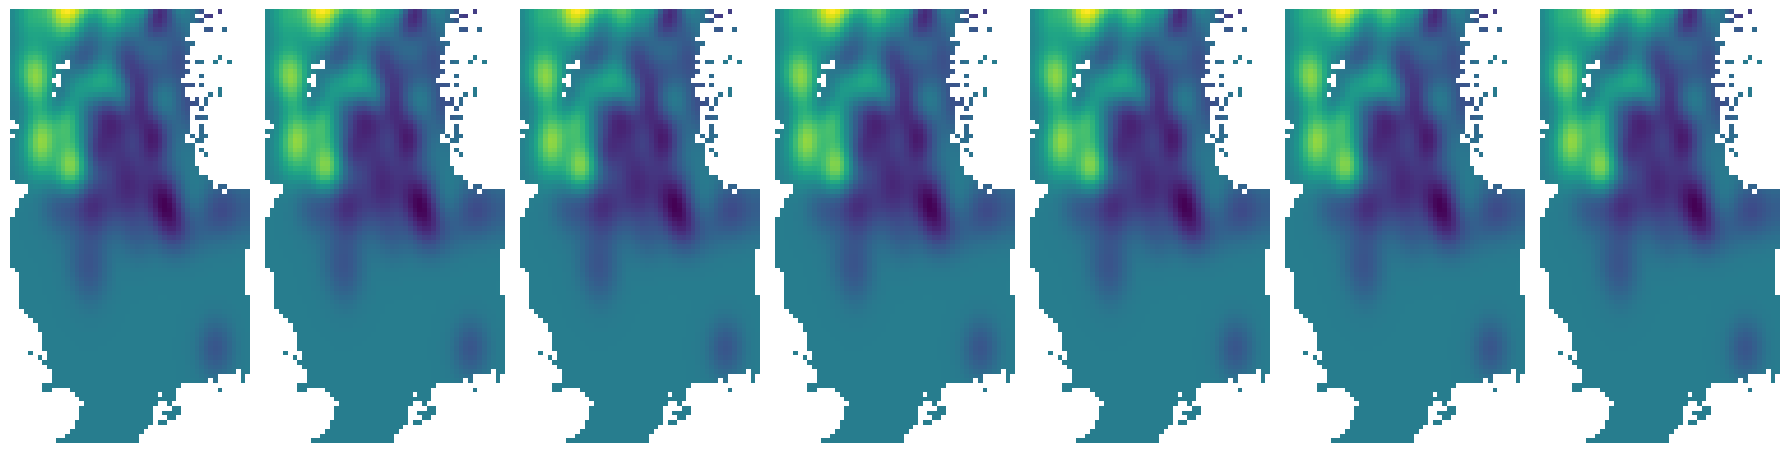

In [25]:
plt.figure(figsize=(18, 6))
for d in range(7):
    plt.subplot(1, 7, d+1)
    plt.imshow(np.ma.masked_where(~ocean_mask, mean_grid[d]))
    plt.axis('off')
plt.tight_layout()
plt.show()